# Scan and detect

Imaging modes such as STEM and ptychography works by scanning an electron probe across a sample and recording the scattering signal. In abTEM, the manner in which the signal is detected is controlled by the detector objects. There is five different types of detectors, each will be described in the following.

## Ring detector
The `RingDetector` can be used for simulating the typical modes of STEM, i.e. bright field and annular dark field measurements. The only difference between these are the inner and outer radial integration limits, below we create a detector representing each mode 

In [1]:
from abtem.detect import AnnularDetector

bright = AnnularDetector(inner=.0, outer=.02, extent=10, sampling=.05, energy=200e3)
maadf = AnnularDetector(inner=.05, outer=.086, extent=10, sampling=.05, energy=200e3)
haadf = AnnularDetector(inner=.086, outer=.19, extent=10, sampling=.05, energy=200e3)

As noted in tutorial, abTEM is generally smart enough to infer the grid and energy from context. However, plotting the integration region as below requires us to explicitly set these values.

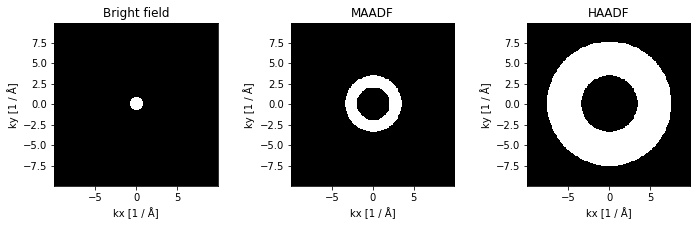

In [2]:
import matplotlib.pyplot as plt

fig, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(12,3))

bright.get_integration_region().plot(ax=ax1, title='Bright field')
maadf.get_integration_region().plot(ax=ax2, title='MAADF')
haadf.get_integration_region().plot(ax=ax3, title='HAADF')

As noted in an earlier tutorial, the sampling should be fine enough, that the maximum spatial frequency is twice the outer integration limit. Let's fix this by decreasing the pixel size

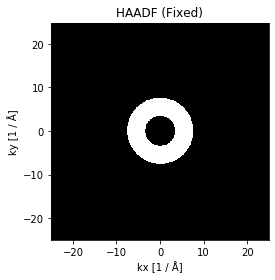

In [3]:
haadf.sampling = .02
haadf.get_integration_region().plot(title='HAADF (Fixed)')

## Segmented detector

The `SegmentedDetector` is partitioned into several integration regions divided at radials and angles. This can be used for simulating for simulating differential phase contrast (DPC) imaging. 

In [9]:
from abtem.detect import SegmentedDetector

segmented_detector = SegmentedDetector()


Another use of this detector is as a flexible `AnnularDetector`

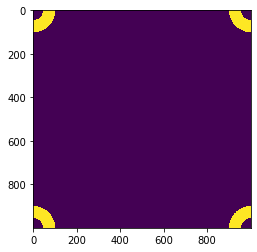

In [14]:
detector = RingDetector(inner = .09, outer = .2, sampling=.01, extent=10, energy=300e3)

efficiency = detector.get_efficiency()

plt.imshow(efficiency.array)


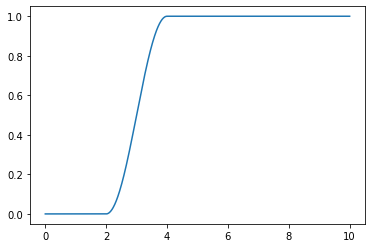

In [7]:
from abtem.utils import cosine_window
import matplotlib.pyplot as plt
import numpy as np

x = np.linspace(0,10,1000)
y = cosine_window(x, 2, 1, invert=True)

plt.plot(x,y)

## Pixelated detector

This `PixelatedDetector` object saves the intensity of the fourier transformed exit wave function, i.e. a complete convergent beam electron diffraction pattern is recorded at every pixel in a scan of the sample in a large four-dimensional dataset (a 2D diffraction pattern recorded at every 2D probe position). The 4D datasets generated can be analyzed to reconstruct images equivalent to those of any conventional detector geometry. The only downside to this is the high memory or disk space requirement of storing the data. 

## Custom detector

The `CustomDetector` allows the user to set the detector efficiency using an array, e.g. representing a measured detector efficiency.

## Wave detector
This detector simply saves the complex probe array at each position, and hence does not throw any information away. 




## Detectors
abTEM has several detector types, we will highlight the main ones





In [ ]:
from abtem.detect import RingDetector



The following is generally unnecesseary. We show the Fourier space integration region of the 
We , the detector also have to match the wave function. 

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(12,4))

ax1.imshow(np.fft.fftshift(bright_efficiency.array), extent=bright_efficiency.fourier_limits.ravel() * 
           bright_efficiency.wavelength * 1e3)
ax1.set_title('Bright field')

ax2.imshow(np.fft.fftshift(maadf_efficiency.array), extent=maadf_efficiency.fourier_limits.ravel() * 
           maadf_efficiency.wavelength * 1e3)
ax2.set_title('MAADF')

ax3.imshow(np.fft.fftshift(haadf_efficiency.array), extent=haadf_efficiency.fourier_limits.ravel() * 
           haadf_efficiency.wavelength * 1e3)

### Fourier space detector
The `FourierSpaceDetector` saves the fourier space instensity of the exit probe wave function at every scan position. Using this detector it is possible to manually define any integration region afterwards the downside to using this is that a full 4D dataset takes a lot of disc space or memory.

In [2]:
from abtem.detect import FourierSpaceDetector

### Polar detector

In [5]:
from abtem.plot import plot_image

bright.match_grid_and_energy(probe)

bright_efficiency = bright.get_efficiency()

plot_image(bright)

AttributeError: 'ArrayWithGridAndEnergy' object has no attribute 'shape'

In [ ]:



maadf_efficiency = maadf.get_efficiency()
haadf_efficiency = haadf.get_efficiency()


ax3.set_title('HAADF')

for ax in (ax1,ax2,ax3):
    ax.set_xlabel('alpha_x [mrad]')
    ax.set_ylabel('alpha_y [mrad]')

plt.tight_layout()